 # [Module 2.5] CatBoost 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 데이터 로딩
- Category 인덱스 추출
- CatBoost 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
import pandas as pd

In [2]:
%store -r te_pre_train_file
# %store -r pre_val_file
%store -r te_pre_test_file

In [3]:
te_pre_train_file

'preproc_data/fe/te_xgboost/train.csv'

## 훈련, 검증 데이터 세트 로딩

In [4]:
train_df = pd.read_csv(te_pre_train_file, header=None, skiprows=1)
# val_df = pd.read_csv(pre_val_file, header=None, skiprows=1)
print("train_df: ", train_df.shape)
# print("val_df: ", val_df.shape)

train_df:  (53740, 19)


In [5]:
from IPython.display import display
display(train_df.head())
# display(val_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,29.99,10.96,9000.0,2640.0,1,4,10,2.169916,2.634373,2.081289,1.796930,1.701281,2.192347,1.633632,2.169544,2.273400,1.769943,2.201493
1,2,23.90,26.82,1500.0,14625.0,1,4,10,2.191720,2.217699,2.097592,2.210910,2.150079,2.194351,3.143455,2.205518,2.208892,3.195302,2.186005
2,4,249.90,17.59,610.0,4928.0,1,4,10,2.206125,2.005063,2.156330,2.133891,2.104642,2.163367,2.612756,2.165219,2.335182,2.488399,2.159966
3,4,89.90,17.51,1850.0,10764.0,1,4,10,2.250395,2.169863,2.092833,1.891487,2.171051,2.210502,2.625672,2.143322,2.668535,2.507481,2.144182
4,2,93.90,17.61,1200.0,12500.0,1,4,10,2.193097,2.230287,2.471783,2.141343,2.174232,2.212063,2.790628,2.153706,2.480000,2.463472,2.187718


In [6]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0]
# X_val, y_val = val_df.iloc[:,1:], val_df.iloc[:,0]

## 레이블 인코딩된 category 인덱스 추출
- CatBoost 알고리즘에 category 인덱스를 알려 주기 위해서 임

In [7]:
cat_features_index = X_train.columns[X_train.dtypes == 'int64'].tolist()
cat_features_index = [num -1 for num in cat_features_index]
cat_features_index

[4, 5, 6]

## CatBoost 훈련


In [8]:
%%time 

import catboost as cb

clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
                           iterations = 500)
# clf.fit(X_train, y_train, verbose=False, cat_features = cat_features_index)
clf.fit(X_train, y_train, verbose=False)


CPU times: user 4min 31s, sys: 5.76 s, total: 4min 37s
Wall time: 9.76 s


In [9]:
# clf.score(X_val, y_val)

## Test 데이터로 평가

In [10]:
test_df = pd.read_csv(te_pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,105.00,23.89,1000.0,7632.0,1,19,6,2.383450,2.248060,2.139111,2.071608,2.670790,2.215037,2.208833,2.192865,2.584195,2.652646,2.177167
1,0,99.97,15.80,650.0,9600.0,1,19,6,2.193994,2.039612,2.350234,1.957532,2.155151,2.150895,2.239534,2.174192,1.625256,1.816853,2.202125
2,3,76.99,23.34,1850.0,3000.0,1,19,6,2.182470,1.929809,2.073995,1.936101,2.147201,2.200517,2.640028,2.189071,2.184426,2.505653,2.175313
3,2,64.90,15.55,200.0,4752.0,1,19,6,2.187051,2.181686,2.068987,1.975613,2.170997,2.616731,2.612363,2.177088,2.439227,2.485332,2.173503
4,4,75.00,27.51,2550.0,31500.0,1,19,6,2.160452,2.227946,2.078289,1.956637,2.178010,2.191192,2.854430,2.189942,2.811362,2.840689,2.207974


In [11]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [12]:
prediction = clf.predict(X_test)

## 모델 평가

In [13]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.45%
f1_score: 0.43%


[[ 926  453  299   24    3]
 [ 331 1280 1720  737   94]
 [ 189  393 2482 1026  445]
 [  54  168  636 1063  247]
 [  16   53  274  250  273]]


<Figure size 432x288 with 0 Axes>

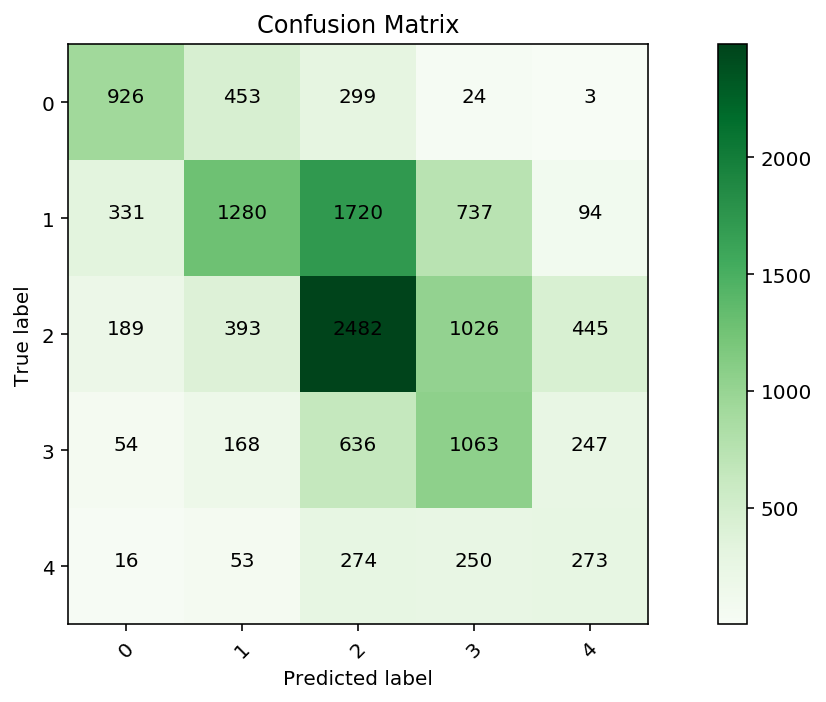

In [14]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

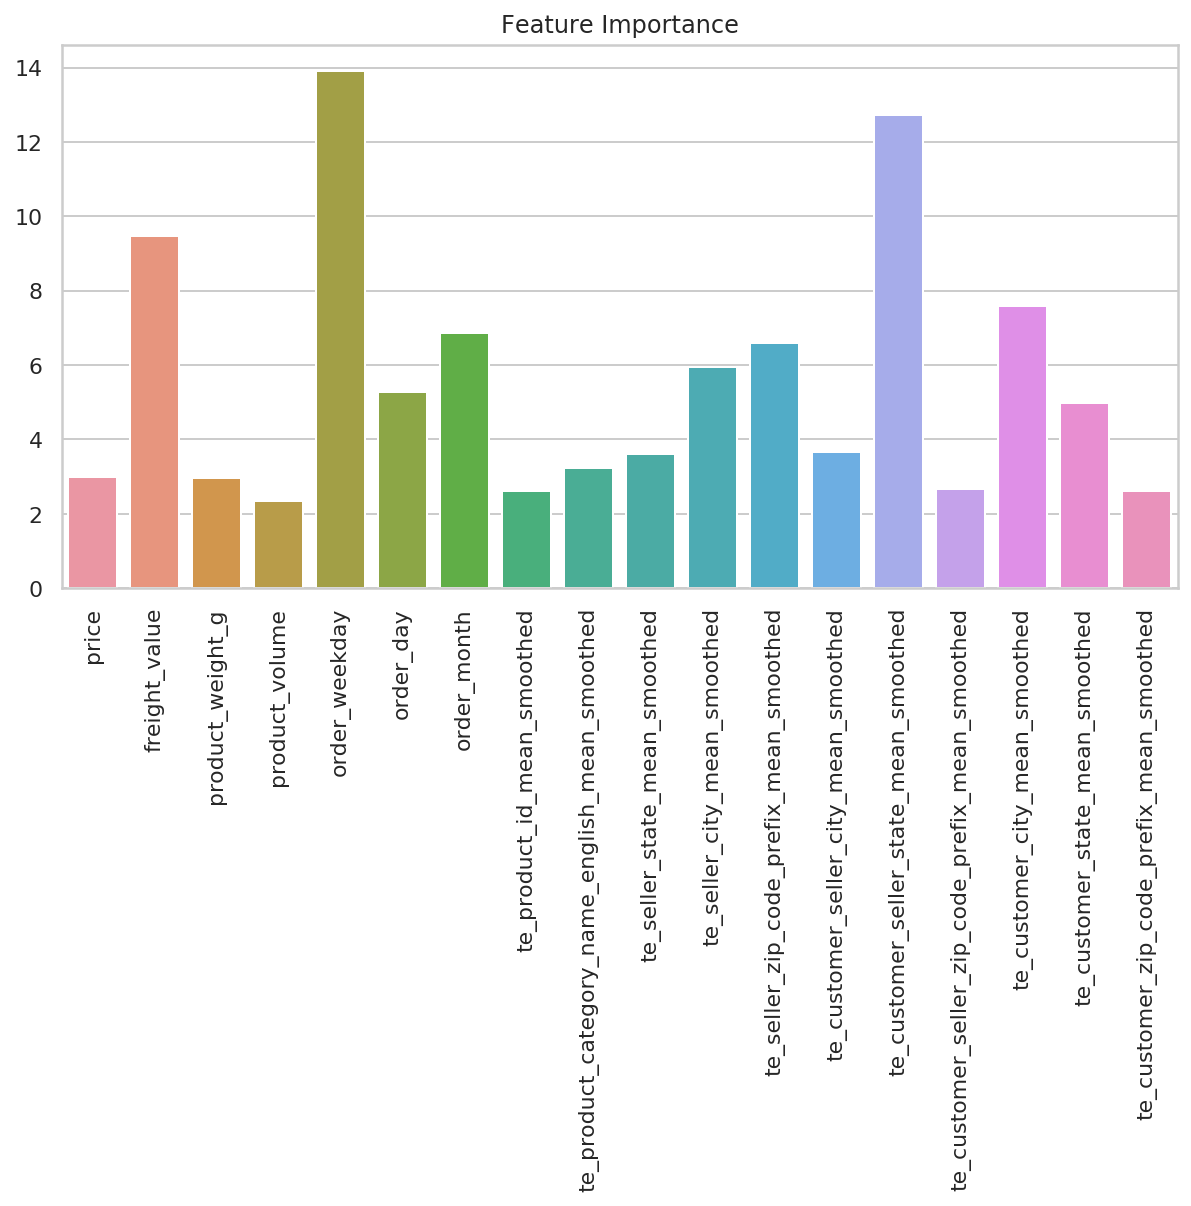

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


test_col_df = pd.read_csv(te_pre_test_file)
features = test_col_df.columns[1:]
fea_importance = clf.feature_importances_

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()